In [1]:
%matplotlib inline

# PYTORCH: DEFINING NEW AUTOGRAD FUNCTIONS

同样的回归问题，但这次我们要实现一个自己的ReLU函数，并增加它的自动求导功能。

In [8]:
import torch 

class MyReLU(torch.autograd.Function):
    """
    通过继承torch.autograd.Function来实现我们的ReLU函数。
    需要实现它的正向和反向传播。
    """
    
    @staticmethod
    def forward(ctx, input):
        """
        在forward函数中，我们获取一个Tensor作为参数input，return输出。
        ctx是一个上下文对象，它能保存反向传播的信息，你能随意地保存一个对像
        通过ctx.save_for_backward方法。
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        在反向传播过程里，我们接受一个包含梯度的Tensor，
        这个梯度是dloss/doutput.
        接下来要计算dloss/dinput.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

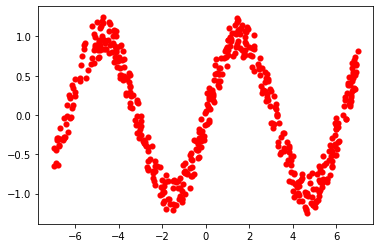

In [7]:
import numpy as np
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# N是batch_size； D_in是输入的维度
# H是隐层的维度；D_out是输出的维度
N, D_in, H, D_out = 512, 1, 100, 1

#创建数据集，y通过sin函数计算并加上部分噪声
x = np.random.rand(N, D_in)
x = (x - 0.5) * 14
y = np.sin(x) + (np.random.rand(N, D_out) - 0.5) * 0.5
plt.scatter(x,y,color="red", linewidth=0.1)
x = torch.from_numpy(x).type(dtype).to(device)
y = torch.from_numpy(y).type(dtype).to(device)

In [13]:
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
b1 = torch.randn(H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)
b2 = torch.randn(D_out, device=device, dtype=dtype, requires_grad=True)

lr_w = 1e-6
lr_b = 1e-5

for epoch in range(50000):
    relu = MyReLU.apply
    y_pred = relu((x.mm(w1) + b1)).mm(w2) + b2
    loss = (y_pred - y).pow(2).sum()
    if epoch % 1000 == 0:
        print("epoch:",epoch, "loss:", loss.item())
    
    loss.backward()
    
    with torch.no_grad():
        w1 -= lr_w * w1.grad
        b1 -= lr_b * b1.grad
        w2 -= lr_w * w2.grad
        b2 -= lr_b * b2.grad
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()
    
y_pred = (x.mm(w1) + b1).clamp(min=0).mm(w2) + b2
plt.scatter(x.detach().cpu().numpy(),y.detach().cpu().numpy(),color="red", linewidth=0.1)
plt.scatter(x.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), color='green', linewidth=0.1)

TypeError: forward() missing 1 required positional argument: 'input'

In [12]:
torch.autograd.Function?